#Taller 3 Machine Learning Kernels and SVM’s
#$Integrantes$:
>Juan Felipe Baquero Vargas

>Lina Fernanda Rosales Castro




Se realizan los imports necesarios para la actividad

In [1]:
%matplotlib inline
import sklearn as skl
import numpy as np
import pylab as pl
import pandas as pd
from IPython.display import display, Math, Latex
from sklearn import svm

In [52]:
def doPlot( prediccion, realVal, labels, ordenar=1, tieneX=0,ejeX=1,labelX='X', labelY='Y', titulo='Gafica'):
    if ordenar==1:
        pred = sorted( prediccion , reverse=True)
        vals = sorted( realVal , reverse=True)
    else:
        pred = prediccion 
        vals = realVal 
    #print ejeX
    if tieneX==0:
        ejeX = np.arange( len(pred) )
    #print ejeX
    pl.clf()
    pl.title( titulo );
    pl.plot(ejeX, pred, 'gx', label=labels[0])
    pl.plot(ejeX, vals, 'r.', label=labels[1])
    pl.legend( bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
    pl.xlabel( labelX )
    pl.ylabel( labelY )
    pl.show()

In [3]:
def calcularError( prediccion, valReal):
    pred = prediccion
    vals = valReal
    dif = np.dot(pred-vals, pred-vals)*1.0/pred.shape[0]
    return dif

In [4]:
#Separa label de dato.
def separarDatos( datos ):
    lab = [ data[0] for data in datos]
    dato = [ data[1:] for data in datos]
    return lab, dato

##Punto 1

###A - Expresión utilizando kernerls


Dado un vecto $w$ en $X$, calcular la norma de la proyección de la imagen en un punto $x$,$\phi(x)$ en la imagen del vector $w$, $\phi(w)$:

$$P_{\phi(w)}\left(\phi(x)\right)=\frac{\langle\phi(x),\phi(y)\rangle}{\Vert\phi(w)\Vert}$$

Por la definición de kernel y la defición de la norma como producto punto: 
$\Vert x\Vert = \langle x, x\rangle^\frac{1}{2}$, se tiene que:
$$P_{\phi(w)}\left(\phi(x)\right)= \frac{ k(x,w)}{ k(w,w)^{\frac{1}{2}}}$$


### B - Varianza de las proyecciones

Calcular la varianza de las proyeciones en un espacio de un conjunto de puntos a lo largo de un vector $w$:
$$\mathrm{Var}_{\phi(w)}(x) = \frac{1}{n}\sum_{x_i\in x}\left( P_{\phi(w)}(\phi(x_i))-\mu \right)^2$$

donde

$$\mu = \frac{1}{n}\sum_{x_i\in x} P_{\phi(w)}(\phi(x_i))$$

Utilizando el resultado del literal A se tiene que:
 
 $$\mathrm{Var}_{\phi(w)}(x) = \frac{1}{n}\sum_{x_i\in x}\left( \frac{ k(x,w)}{ k(w,w)^{-\frac{1}{2}}})-\mu \right)^2$$
 
 donde 

$$\mu = \frac{1}{n k(w,w)^{\frac{1}{2}}}\sum_{x_i\in x} k(x_i,w)$$

###C - Implementacion en Python

In [132]:
#Definiciòn de kernels
def kernel1(x,w):
    return np.dot(x,w)

def kernel2(x,w):
    return np.dot(x,w)**2

def kernel3(x,w):
    return (np.dot(x,w) + 1)**5

def kernel4(x,w):
    aux = x - w
    return np.exp(-0.5 *np.dot(aux,aux))

#Varianza y proyeccion
def projection(x,w,k):
    return (k(x,w)/(k(w,w)**.5))

def variance(xs, w, k):
    n = len(xs)
    proj = np.array([projection(x,w,k) for x in xs])
    m = np.mean(proj)
    
    rest = (proj - m)**2
    
    suma = np.sum(rest)

    return (1.0/n)*suma
    
    

In [133]:
xs = np.array([[ 0,  1], 
               [-1,  3],
               [ 2,  4],
               [ 3, -1],
               [-1, -2]])

w1 = np.array([ 1, 1])

w2 = np.array([ -1, 1])

ks = [kernel1,kernel2,kernel3,kernel4]

In [135]:
wk1 = []
wk2 = []

for idx in xrange(len(ks)):
    wk1.append((variance(xs,w1,ks[idx])))


for idx in xrange(len(ks)):
    wk2.append(variance(xs,w2,ks[idx]))

wk1=np.array(wk1)
wk2=np.array(wk2)

wk1 = wk1.T
wk2= wk2.T
wi = zip(wk1,wk2)

pd.DataFrame(data=wi, columns=['$\mathbf{w}_1$', '$\mathbf{w}_2$'], index=['Kernel 1', 'Kernel 2', 'Kernel 3', 'Kernel 4'])

,$\mathbf{w}_1$,$\mathbf{w}_2$
Kernel 1,4.120000,3.720000
Kernel 2,41.340000,12.060000
Kernel 3,183362.819095,6494.993580
Kernel 4,0.056747,0.054575


##Punto 2

###(a) Implement a function that calculates a kernel over fixed-length strings
> $k : Σ^d × Σ^d → R,$

which counts the number of coincidences between two strings.


In [6]:
#Se asume que ambos strings tienen la misma longitud
def coincidences( str1, str2):
    n = len( str1 )
    cnt = 0
    for idx in xrange( n ):
        cnt += (str1[idx]==str2[idx])
    return cnt

In [7]:
print coincidences("GCTCCTAAT", "CGTTGCCAT")

3


In [8]:
#Funcion Que retorna la funcion de Kernel que usaremos
def kernelStrings1():
    return coincidences

###(b) Implement Kernel Ridge Regression (KRR)


Se implementa la clase KRR que hace Kernel Ridge Regression, esta usa los metodos fit y predict

In [9]:
class KRR:
    
    def __init__(self, kernel ,alpha=1.0):
        """
            Inicializacion
            
            Parameters
            ----------
            alpha: {float}
            kernel: {function} Funcion de kernel
        """
        self.kernel = kernel()
        self.alpha = alpha
        self.K = [0]
        
    def getKernel(self, X ):
        #print self, X, self.kernel
        kernel = self.kernel
        K = []
        for x in X:
            row = []
            for y in X:
                res = kernel(x, y)
                row.append( res )
            K.append(row)
        
        self.K = np.array(K)
        return self.K
        
    def fit(self, X, Y):
        """
            Kernel Ridge regression
            
            Parameters
            ----------
            alpha: {float}
        """
        self.X = X
        n_samples = X.shape[0]
        K = self.getKernel(X)
        _lambda = self.alpha
        self.I = np.identity( n_samples )
        self.inv = np.linalg.inv( K-_lambda*self.I )
        self.a = np.dot( self.inv, Y)
        return self
    
    def predict( self, X ):
        Kxxi = np.array( [ [ self.kernel(x, xi) for xi in self.X ] for x in X] )
        Gx = np.dot(self.a, Kxxi.T)
        return Gx

Para probar El KRR se prueba con un ejemplo parecido al realizado en clase

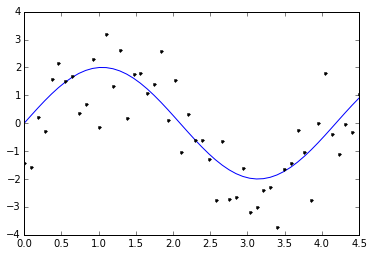

In [10]:
#Funciones para generar datos

def genFuntion( size ):    
    x = np.linspace( 0, 4.5, size )
    y = 2*np.sin( x*1.5 )
    return (x,y)

def genSample( size ):
    x = np.linspace( 0, 4.5, size )
    y = 2*np.sin( x*1.5 )+pl.randn( x.size )
    return (x,y)

size = 50
pl.clf()
f_x, f_y = genFuntion( size )
pl.plot( f_x, f_y )
x, y = genSample( size )
pl.plot(x, y, 'k.')

In [11]:
#Se adapta las funciones anteriores para aplicarlas al modelo creado
def function2( x, x2 ):
    return 2*np.sin( x*1.5 )
def kfun():
    return function2;

#Se crea y entrena el modelo
nueva = KRR( kfun, alpha=0.001 )
XX = np.linspace( 0, 4.5, size )
YY = 2*np.sin( x*1.5 )
nueva.fit(XX, YY)

<__main__.KRR instance at 0x000000000D1C9A88>

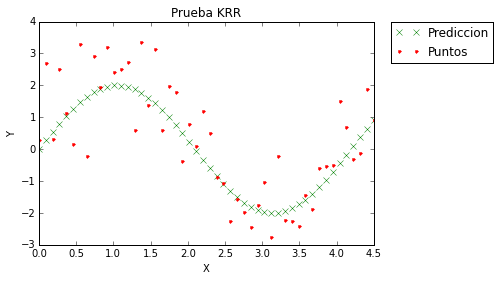

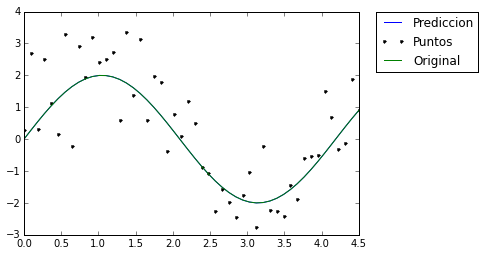

In [13]:
#Se generan nuevos datos y se usa el modelo para realizar la prediccion
auxSample = genSample( size )
pred = nueva.predict( f_x )

doPlot( pred, auxSample[1], ["Prediccion", "Puntos"], tieneX=1,ejeX=XX, ordenar=0, titulo="Prueba KRR")
pl.clf()
pl.plot( XX, pred, 'b-', label="Prediccion")
pl.plot(XX, auxSample[1], 'k.', label="Puntos")
pl.plot( XX, YY, 'g-', label="Original")
pl.legend( bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

###(c) Use the KRR implementation and the kernel k to train a model using the training data set

In [15]:
#Lectura de archivo de Entrenamiento
data = open( "Data/assign3-train.txt" )
lines = data.read().splitlines()
samples = [sample.split(" ") for sample in lines]
train = [ [sample[0], float(sample[1]) ] for sample in samples ]
print len(train), train[0:10], train[-10:]
#train = sorted(train, key=lambda tr: tr[1], reverse=True)
#print len(train), train[0:10], train[-10:]

100 [['CAAAGCCGG', -5.18906325187], ['TCATCCCTG', 4.28131606936], ['TGGCGTGCT', -0.301845302067], ['ACTGGGGGT', 3.70180552666], ['AAAGCATAG', 3.14257941172], ['TCTGCGCTG', 2.38908427031], ['TGTCGGATC', -2.27475563403], ['GGGTGTAGT', 11.9965070838], ['TACTTACCT', 10.6932370111], ['GTGTGTAAC', 17.2780782385]] [['CAAAAGCTA', -8.40289938286], ['ATTTGAAGC', 15.0439926937], ['AGCTACGAC', 13.813575869], ['CGCCTGCGA', -3.01635108622], ['CGAATTTGA', -7.41529147849], ['GACAATTAA', -1.42028504423], ['TGAGCGGTG', -2.28253395251], ['CAAAGGAAC', -0.297865952995], ['GTCTAGTGT', 8.46070369256], ['CGTTTTTAA', 17.0156355679]]


In [16]:
trainT = np.array(train).T
model = KRR( kernelStrings1 , alpha=0.1)
model.fit(trainT[0], map(float,trainT[1]) )
print model

<__main__.KRR instance at 0x0000000017AB7488>


In [17]:
pred = model.predict(trainT[0])
vals = map(float, trainT[1])
dif = [ (pred[idx]-vals[idx])**2  for idx in xrange( len(pred) ) ]
display( Math(r"Error="+ str(sum(dif)/len(pred) ) ) )
display( Math(r"ErrorRSM="+ str( calcularError(pred, vals) ) ) )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

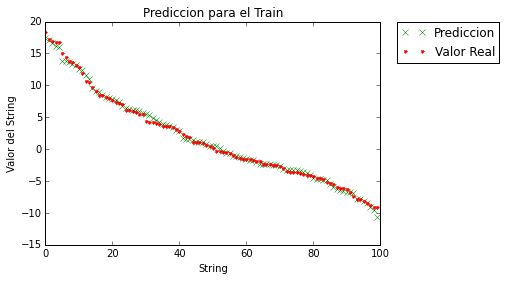

In [18]:
doPlot(pred, vals, ["Prediccion", "Valor Real"], labelX="String"
       , labelY="Valor del String", titulo="Prediccion para el Train")

###(d) Evaluate the trained model on the test data set

In [19]:
#Lectura de archivo de Test
data = open( "Data/assign3-test.txt" )
lines = data.read().splitlines()
samples = [sample.split(" ") for sample in lines]
test = [ [sample[0], float(sample[1]) ] for sample in samples ]
print len(test), test[:10], test[-10:]

50 [['GCTCCTAAT', 4.19273502554], ['CGTTGCCAT', 18.7690763817], ['GCCGTTCCT', 3.88305315574], ['GTCACTTGC', -7.06261561113], ['ATGTTTCGC', 11.2989859292], ['ACATATTCA', 7.27588038698], ['GTCTATGAG', 14.0355784595], ['GTCTGAAGT', 10.6277237323], ['CACACTACA', -2.88462311742], ['ATTTCACTG', 11.9747557709]] [['AGTTGACGC', 13.7349935357], ['GGTCGTGTC', -4.41285301185], ['TTTTGCTGA', 12.8972544772], ['TGAAGCTTC', -9.55596489916], ['CAGAGAGTA', -7.88802538885], ['CGAAGTAGT', -4.70641347], ['TACGTTTTG', -2.60943519735], ['TCAAGAGCA', -3.04374654509], ['CGGCCCTCG', -0.433408806264], ['GGCTGACCA', 11.5845831453]]


In [20]:
testT = np.array(test).T
pred = model.predict(testT[0])
vals = map(float, testT[1])
dif = [ (pred[idx]-vals[idx])**2  for idx in xrange( len(pred) ) ]

display( Math(r"Error="+ str(sum(dif)/len(pred) ) ) )
display( Math(r"ErrorRSM="+ str( calcularError(pred, vals) ) ) )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

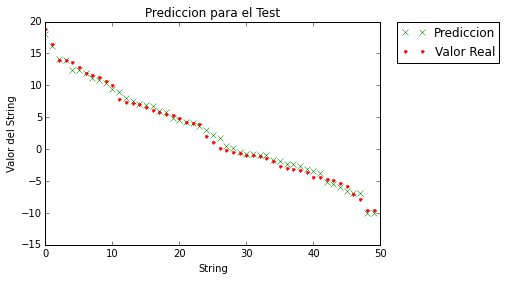

In [21]:
doPlot(pred, vals, ["Prediccion", "Valor Real"], labelX="String"
       , labelY="Valor del String", titulo="Prediccion para el Test")

###(e) Build a new kernel, $k'$, composing the kernel k with more complex kernel (polynomial, Gaussian, etc). Repeat steps (b) and (c). For instance, the new kernel may be defined as:
>$k'(x, y) = (k(x, y) + 1)^d$

where d is positive integer exponent.

In [22]:
#definir nueva funcion y kernel
def coincidences2( str1, str2):
    return (coincidences(str1, str2)+1)**3
def kernelStrings2():
    return coincidences2

In [23]:
#definir nueva funcion y kernel
def gaussian( str1, str2):
    from scipy.spatial.distance import pdist, squareform
    sigma2 = 10**2;
    vals = 0
    for idx in xrange( len(str1) ):
        vals += abs( ord(str1[idx] )-ord(str2[idx])-2*ord('A') )
    return vals**2/sigma2
def kernelStrings3():
    return gaussian

In [24]:
model2 = KRR( kernelStrings2 , alpha=0.1)
model2.fit( trainT[0], map(float, trainT[1]) )

<__main__.KRR instance at 0x0000000019012348>

###(e)->(c

In [25]:
pred = model2.predict(trainT[0])
vals = map(float, trainT[1])
dif = [ (pred[idx]-vals[idx])**2  for idx in xrange( len(pred) ) ]
display( Math(r"Error="+ str(sum(dif)/len(pred) ) ) )
display( Math(r"ErrorRSM="+ str( calcularError(pred, vals) ) ) )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

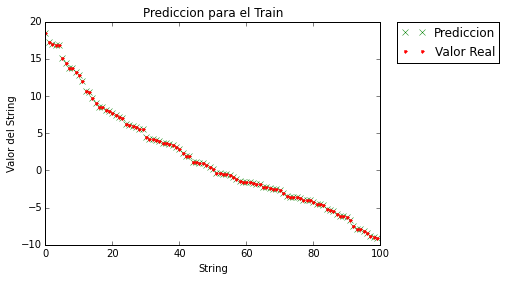

In [26]:
doPlot(pred, vals, ["Prediccion", "Valor Real"], labelX="String"
       , labelY="Valor del String", titulo="Prediccion para el Train")

###(e)->(d)

In [27]:
pred = model2.predict(testT[0])
vals = map(float, testT[1])
dif = [ (pred[idx]-vals[idx])**2  for idx in xrange( len(pred) ) ]
display( Math(r"Error="+ str(sum(dif)/len(pred) ) ) )
display( Math(r"ErrorRSM="+ str( calcularError(pred, vals) ) ) )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

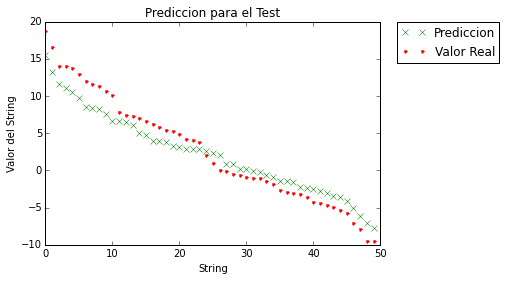

In [30]:
doPlot(pred, vals, ["Prediccion", "Valor Real"], labelX="String"
       , labelY="Valor del String", titulo="Prediccion para el Test")

##Punto 3

###A - Get the data from the Digit Recognizer problem

In [31]:
def showData( arch ):
    data =pd.read_csv( arch )
    print data
    return data['label']

labels = showData( "Data/train.csv" )

       label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0          1       0       0       0       0       0       0       0       0   
1          0       0       0       0       0       0       0       0       0   
2          1       0       0       0       0       0       0       0       0   
3          4       0       0       0       0       0       0       0       0   
4          0       0       0       0       0       0       0       0       0   
5          0       0       0       0       0       0       0       0       0   
6          7       0       0       0       0       0       0       0       0   
7          3       0       0       0       0       0       0       0       0   
8          5       0       0       0       0       0       0       0       0   
9          3       0       0       0       0       0       0       0       0   
10         8       0       0       0       0       0       0       0       0   
11         9       0       0       0    

In [5]:
def readData( arch , cabecera=0):
    data = open( arch )
    lines = data.read().splitlines()
    idx = 0
    if cabecera!=0:
        idx = 1
    #return lines
    imagenes = np.array([ [ int(val) for val in line.split(",")]  for line in lines[idx:] ])
    return imagenes

In [6]:
imagenes = readData( "Data/train.csv" , cabecera=1)
#print np.array(imagenes[1])

In [53]:
#Pasa el arreglo de 784 a una matriz de 28x28
def toImage( arr, label=0, nRows=28):
    if( label!=0 ):
        arr = arr[1:]
    n = len(arr)
    image = [[]]*nRows
    for idx in xrange(nRows):
        image[idx] = arr[idx*nRows:(idx+1)*nRows] 
    return np.array(image)

#Imprime la matriz y llama a ToImage
def printImage( arrayImage, label=1, nRows=28, rgb=1):
    image = toImage( arrayImage, label=label )
    titulos = ["Grafica", "Imagen de "+str(arrayImage[0])]
    title = titulos[label]
    pl.clf()
    pl.title( title )
    if rgb==1:
        cmap= pl.get_cmap('gray_r') 
        pl.imshow( image, cmap)
    else:
        pl.imshow( image )
    pl.show()

In [8]:
nClases = 10
claseImagen = [ [] for idx in xrange(nClases) ]
claseImagenL = [ [] for idx in xrange(nClases) ]

for imagen in imagenes:
    claseImagen[ imagen[0] ].append( imagen[1:] )
    claseImagenL[ imagen[0] ].append( imagen )


print "IDX\tTam Comjunto"
for idx in xrange( nClases ):
    print "{0}\t   {1}".format(idx, len(claseImagen[idx]) )

IDX	Tam Comjunto
0	   4132
1	   4684
2	   4177
3	   4351
4	   4072
5	   3795
6	   4137
7	   4401
8	   4063
9	   4188


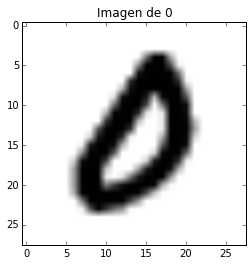

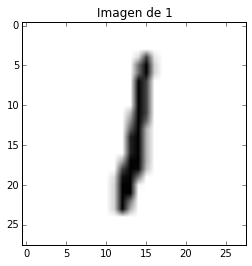

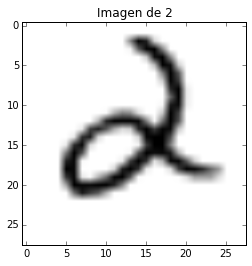

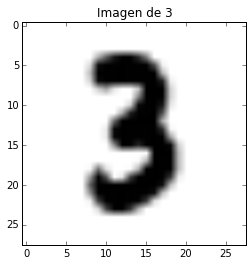

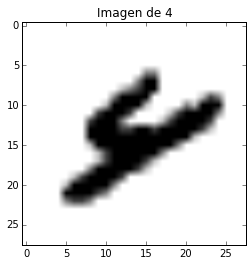

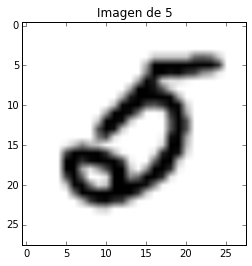

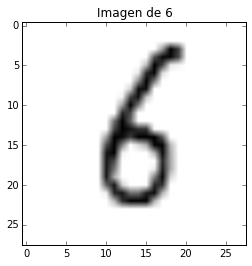

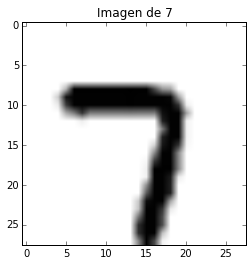

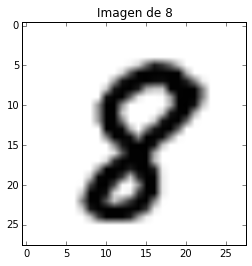

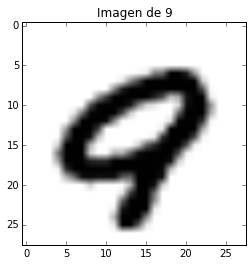

In [41]:
for idx in xrange( nClases ):
    printImage( claseImagenL[idx][-42] )

In [8]:
nuevoConjunto = imagenes#claseImagenL[5]+claseImagenL[3]
trainP3, testP3 = skl.cross_validation.train_test_split(nuevoConjunto, test_size=0.5)
print "Tamano Train {0}, Tamano Test {1}".format( len(trainP3), len(testP3) )


Tamano Train 21000, Tamano Test 21000


In [43]:
display(Math(r'Train'))
print np.array(trainP3[:5])
display(Math(r'Test'))
print np.array(testP3[:5])

<IPython.core.display.Math object>

[[9 0 0 ..., 0 0 0]
 [4 0 0 ..., 0 0 0]
 [8 0 0 ..., 0 0 0]
 [9 0 0 ..., 0 0 0]
 [3 0 0 ..., 0 0 0]]


<IPython.core.display.Math object>

[[3 0 0 ..., 0 0 0]
 [7 0 0 ..., 0 0 0]
 [9 0 0 ..., 0 0 0]
 [4 0 0 ..., 0 0 0]
 [7 0 0 ..., 0 0 0]]


In [45]:
labelP3, dataP3 = separarDatos( trainP3 )
clf = svm.LinearSVC( C=100 )
clf.fit(dataP3, labelP3)

LinearSVC(C=100, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='l2', multi_class='ovr', penalty='l2',
     random_state=None, tol=0.0001, verbose=0)

In [46]:
labelTest3, dataTest3 = separarDatos( testP3 );
sol = clf.predict( dataTest3 )

In [47]:
#Revisa los que estan mal clasificados
dif = [ idx for idx in xrange( len(sol) ) if labelTest3[idx]!=sol[idx] ]

In [48]:
print len(dif), len(labelTest3)

2903 21000


Missmatch 5  Correct 4


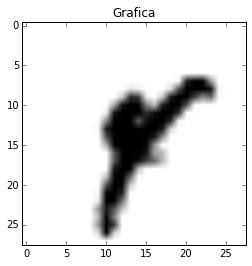

Missmatch 7  Correct 9


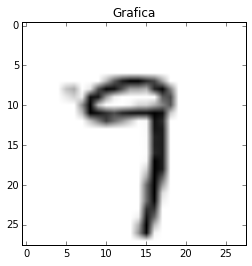

Missmatch 9  Correct 7


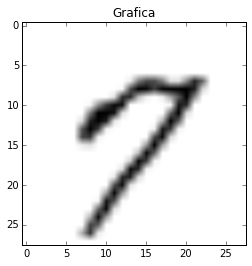

Missmatch 5  Correct 8


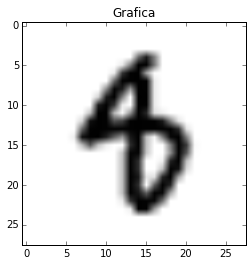

Missmatch 5  Correct 8


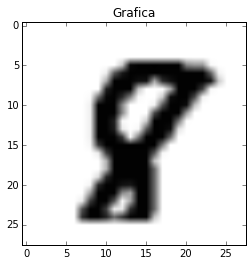

Missmatch 3  Correct 2


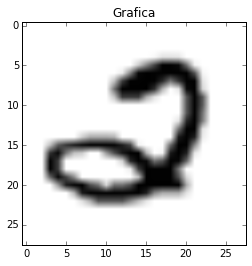

Missmatch 4  Correct 7


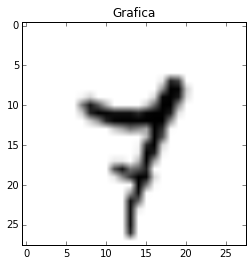

Missmatch 3  Correct 9


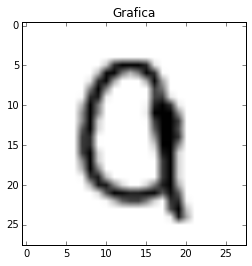

Missmatch 2  Correct 1


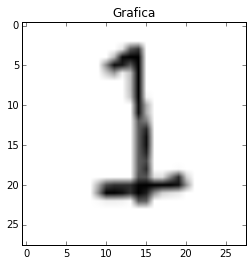

Missmatch 7  Correct 9


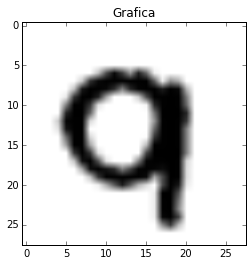

In [49]:
for miss in dif[:10]:
    print "Missmatch", sol[miss], " Correct", labelTest3[miss]
    printImage( dataTest3[miss] ,label=0)


###B - Choose two classes

In [76]:
def clasificarDatos( pc, typeData =0 , imprimirError=1):
    global imagenes, trainP3, testP3
    clf = svm.LinearSVC( C=pc )
    
    if typeData==0 :
        test = trainP3
    else:
        test = testP3
    
    label, data = separarDatos( trainP3 )
    clf.fit(data, label)
    
    labelTest, dataTest = separarDatos( test );
    sol = clf.predict( dataTest )
    
    dif = [ idx for idx in xrange( len(sol) ) if labelTest[idx]!=sol[idx] ]
    
    if imprimirError==1:
        display( Math(r"\% Error "+str(pc)+": {:.2%}".format( len(dif)*1.0/len( labelTest ) )  ) )
    
    error = calcularError( sol, labelTest )
    return error
    

Se eliguen para comparar las clases 5 y 3, se separan los datos en Training y Test con el 60% y 40% de los datos respectivamente.

In [130]:
#Se eligen 2 clases y almancenan los datos en "nuevoConjunto"
nuevoConjunto = claseImagenL[5]+claseImagenL[3]
trainP3, testP3 = skl.cross_validation.train_test_split(nuevoConjunto, test_size=0.4)
print "Tamano Train {0}, Tamano Test {1}".format( len(trainP3), len(testP3) )

Tamano Train 4887, Tamano Test 3259


In [131]:
cs = []
error = []

for pot in xrange( -5, 16 ):
    cs.append( 2**pot )
    error.append( clasificarDatos( 2**pot ) )
    
cs = np.array( cs )
error = np.array( error )

tabla = zip( cs.T, error.T )

pd.DataFrame(data=tabla, columns=['$C$', '$Error$'], index=range(-5,16)).T

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

,-5,-4,-3,-2,-1,0,1,2,3,4,...,6,7,8,9,10,11,12,13,14,15
$C$,0.031250,0.062500,0.125000,0.25000,0.50000,1.000000,2.000000,4.000000,8.000000,16.000000,...,64.000000,128.000000,256.000000,512.000000,1024.000000,2048.000000,4096.000000,8192.000000,16384.000000,32768.000000
$Error$,0.048291,0.042562,0.067935,0.04338,0.06548,0.045836,0.040106,0.035195,0.064661,0.080213,...,0.048291,0.045836,0.097401,0.084305,0.036832,0.045017,0.121956,0.058113,0.035195,0.036832


In [133]:

errorTest = []

for pot in xrange( -5, 16 ):
    
    errorTest.append( clasificarDatos( 2.0**pot, typeData=1) )
    
errorTest = np.array( errorTest )

tabla = zip( cs.T, errorTest.T )
display()
pd.DataFrame(data=tabla, columns=['$C$', '$Error$'], index=range(-5,16)).T

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

,-5,-4,-3,-2,-1,0,1,2,3,4,...,6,7,8,9,10,11,12,13,14,15
$C$,0.031250,0.062500,0.125000,0.250000,0.500000,1.000000,2.000000,4.000000,8.000000,16.000000,...,64.00000,128.000000,256.000000,512.000000,1024.000000,2048.000000,4096.000000,8192.000000,16384.000000,32768.000000
$Error$,0.274931,0.281068,0.273704,0.272476,0.272476,0.287205,0.278613,0.290887,0.266339,0.267567,...,0.27984,0.268794,0.271249,0.268794,0.270021,0.272476,0.274931,0.272476,0.276158,0.265112


In [134]:
sumError = error+errorTest;
tabla = zip(cs.T, sumError.T)
pd.DataFrame(data=tabla, columns=['$C$', '$Error$'], index=range(-5,16))

,$C$,$Error$
-5,0.03125,0.323222
-4,0.06250,0.323630
-3,0.12500,0.341639
-2,0.25000,0.315857
-1,0.50000,0.337956
0,1.00000,0.333041
1,2.00000,0.318719
2,4.00000,0.326082
3,8.00000,0.331001
4,16.00000,0.347780


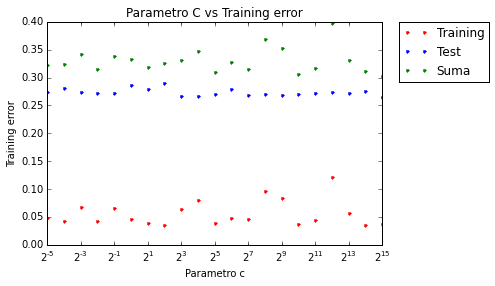

In [135]:
pl.clf()
titulo = str("Parametro C vs Training error")
labelX ="Parametro c"
labelY = "Training error"
pl.title( titulo )
pl.plot(cs,error, 'r.', label="Training")
pl.plot(cs,errorTest, 'b.', label="Test")
pl.plot(cs,sumError, 'g.', label="Suma")
pl.legend( bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
pl.xscale('log', basex=2)
pl.xlabel( labelX )
pl.ylabel( labelY )


Find an Optimal Complexity parameter, C

In [142]:
best = np.argmin( sumError )
display( Math(r'El mejor:'+str(best)) )
display( Math(r'C: 2\^'+str(best-5) ) )
display( Math(r'C:'+str(cs[best]) ) )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

#discuss!!!!!!!!!!!!

###C - Extract the weights of the classification model found in (b).

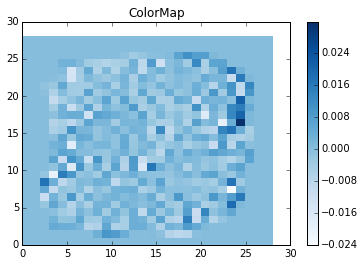

In [143]:
clf = svm.LinearSVC( C=cs[best] )
label, data = separarDatos( trainP3 )
clf.fit(data, label)

weights = clf.coef_.reshape( (28,28) )
pl.title("ColorMap")
pl.pcolor( weights[::-1], cmap='Blues', vmin=np.min(weights), vmax=np.max(weights) )
pl.colorbar()
pl.show()

###D - Plot de discriminant

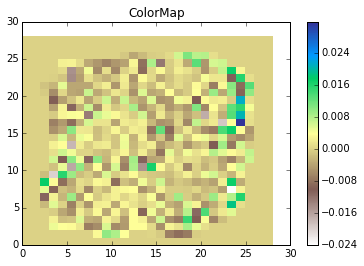

In [166]:
pl.title("ColorMap")
pl.pcolor( weights[::-1], cmap='terrain_r', vmin=np.min(weights), vmax=np.max(weights) )
pl.colorbar()
pl.show()

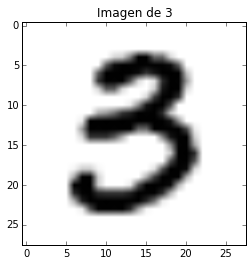

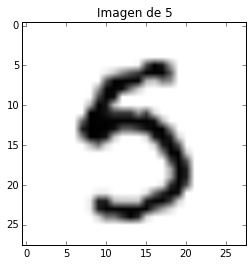

In [169]:
printImage( claseImagenL[3][1069] )
printImage( claseImagenL[5][1069] )

####Discusión de resultados

En el caso del 3 y el 5, el pixel más importante para discriminar el número tres es el la interesseción de las curvas del tres, siendo las curvas del tres los siguientes pixeles más importantes. Para discriminar el número 5 los pixeles más importantes son la línea perpendicular que une el inicio del número y el trazo circular de la parte inferior. Estos pixeles no son tan importantes porque se puede dar el caso de un tres que tenga pixeles en ese lugar. Además se ve una tendencia del número 5 a tener mas pixeles localizados en el lado izquierdo de la gráfica.

###Extra

Se crea una funcion que realize los pasos anteriores, pero dando la posibilidad de elegir las clases a compara

In [150]:
def doPunto3( idx1, idx2, porcentajeTest=0.4 , impError=0):
    global claseImagenL, trainP3, testP3
    print "Se analizara para los conjuntos del {} y el {}".format(idx1, idx2)
    #Se eligen 2 clases y almancenan los datos en "nuevoConjunto"
    nuevoConjunto = claseImagenL[idx1]+claseImagenL[idx2]
    trainP3, testP3 = skl.cross_validation.train_test_split(nuevoConjunto, test_size=porcentajeTest)
    print "Tamano Train {0}, Tamano Test {1}".format( len(trainP3), len(testP3) )
    
    #Se calculan el Error para el conjunto de entrenamiento
    cs = []
    error = []
    for pot in xrange( -5, 16 ):
        cs.append( 2**pot )
        error.append( clasificarDatos( 2.0**pot , imprimirError=impError) )
    cs = np.array( cs )
    error = np.array( error )
    
    #Se imprime los resultados para el conjunto de entrenamiento
    tabla = zip( cs.T, error.T )
    display( Math("Error Train") )
    #print pd.DataFrame(data=tabla, columns=['$C$', '$Error$'], index=range(-5,16)).T
    display( pd.DataFrame(data=tabla, columns=['$C$', '$Error$'], index=range(-5,16)).T )
    
    #Se calculan el Error para el conjunto de Prueba
    errorTest = []
    for pot in xrange( -5, 16 ):
        errorTest.append( clasificarDatos( 2.0**pot, typeData=1, imprimirError=impError) )
    
    errorTest = np.array( errorTest )
    #Se imprime los resultados para el conjunto de Prueba
    tabla = zip( cs.T, errorTest.T )
    display( Math("Error Test") )
    display( pd.DataFrame(data=tabla, columns=['$C$', '$Error$'], index=range(-5,16)).T )
    
    #Se calcula e imprime los resultados del error en los 2 conjuntos
    sumError = error+errorTest;
    tabla = zip(cs.T, sumError.T)
    display( Math("Error Total") )
    display( pd.DataFrame(data=tabla, columns=['$C$', '$Error$'], index=range(-5,16)).T )
    
    print "\n\n\n"
    #Graficando el error vs el parametro C de regularizacion
    pl.clf()
    titulo = str("Parametro C vs Training error")
    labelX ="Parametro c"
    labelY = "Training error"
    pl.title( titulo )
    pl.plot(cs,error, 'r.', label="Training")
    pl.plot(cs,errorTest, 'b.', label="Test")
    pl.plot(cs,sumError, 'g.', label="Suma")
    pl.legend( bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
    pl.xscale('log', basex=2)
    pl.xlabel( labelX )
    pl.ylabel( labelY )
    pl.show()
    
    #Se encuentra el parametro optimo C de regularizacion
    best = np.argmin( sumError )
    display( Math(r'El mejor:'+str(best)) )
    display( Math('C: 2^'+str(best-5) ) )
    display( Math(r'C:'+str(cs[best]) ) )
    
    #Se entrena el modelos Lineal de SVM
    clf = svm.LinearSVC( C=cs[best] )
    label, data = separarDatos( trainP3 )
    clf.fit(data, label)

    #Se  extraen los peso del modelo de clasificacion
    weights = clf.coef_

    #Graficar la funcion discriminante
    weights = weights.reshape( (28,28) )
    pl.clf()
    pl.title("Color Map")
    pl.pcolor( weights[::-1], cmap='rainbow', vmin=np.min(weights), vmax=np.max(weights) )
    pl.colorbar()
    pl.show()

Se analizara para los conjuntos del 3 y el 0
Tamano Train 5089, Tamano Test 3394


<IPython.core.display.Math object>

,-5,-4,-3,-2,-1,0,1,2,3,4,...,6,7,8,9,10,11,12,13,14,15
$C$,0.03125,0.0625,0.125,0.25,0.5,1,2,4,8,16,...,64,128,256,512,1024,2048,4096,8192,16384,32768
$Error$,0.00000,0.0000,0.000,0.00,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<IPython.core.display.Math object>

,-5,-4,-3,-2,-1,0,1,2,3,4,...,6,7,8,9,10,11,12,13,14,15
$C$,0.031250,0.062500,0.125000,0.250000,0.500000,1.000000,2.000000,4.000000,8.000000,16.000000,...,64.000000,128.000000,256.000000,512.000000,1024.000000,2048.000000,4096.000000,8192.000000,16384.000000,32768.000000
$Error$,0.063642,0.063642,0.063642,0.063642,0.063642,0.063642,0.063642,0.063642,0.063642,0.063642,...,0.063642,0.063642,0.063642,0.063642,0.063642,0.063642,0.063642,0.063642,0.063642,0.063642


<IPython.core.display.Math object>

,-5,-4,-3,-2,-1,0,1,2,3,4,...,6,7,8,9,10,11,12,13,14,15
$C$,0.031250,0.062500,0.125000,0.250000,0.500000,1.000000,2.000000,4.000000,8.000000,16.000000,...,64.000000,128.000000,256.000000,512.000000,1024.000000,2048.000000,4096.000000,8192.000000,16384.000000,32768.000000
$Error$,0.063642,0.063642,0.063642,0.063642,0.063642,0.063642,0.063642,0.063642,0.063642,0.063642,...,0.063642,0.063642,0.063642,0.063642,0.063642,0.063642,0.063642,0.063642,0.063642,0.063642


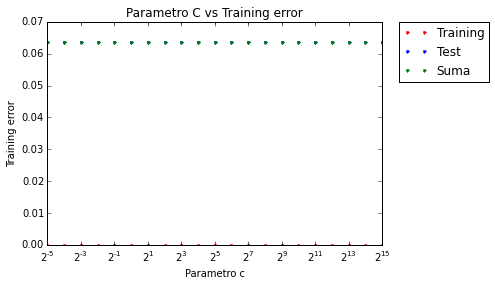

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

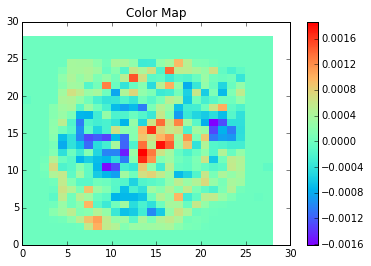

In [170]:
idx1 = 3
idx2 = 0
doPunto3( idx1, idx2)

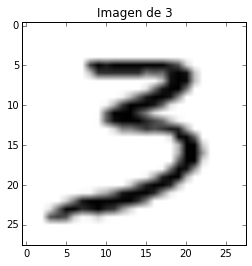

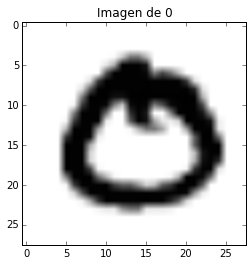

In [171]:
printImage( claseImagenL[idx1][4] )
printImage( claseImagenL[idx2][4] )

####Discusión de resultados

En el caso del 3 y 0, se encuentra una acumulación de pixeles importantes en el centro, ya que el 0 no tiene pixeles en esa área, así mismo se ven pixeles importantes en los bordes de la gráfica sobre todo en el lado izquierdo, lugar donde el número tres no tiene trazos.

### E - Envío a KAGGLE

Se envia la prediccion de las 10 clases utilizando un SVM Lineal

In [4]:
totalTrain = imagenes
testData = readData( "Data/test.csv", cabecera=1)

NameError: name 'imagenes' is not defined

In [51]:
labelP3, dataP3 = separarDatos( totalTrain )
clf = svm.LinearSVC( C=100 )
clf.fit(dataP3, labelP3)

LinearSVC(C=100, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='l2', multi_class='ovr', penalty='l2',
     random_state=None, tol=0.0001, verbose=0)

In [52]:
sol = clf.predict( testData )

Prediccion 2


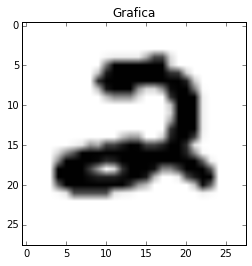

Prediccion 0


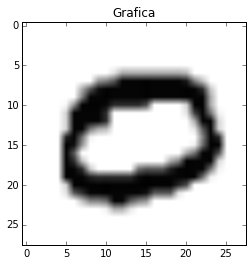

Prediccion 9


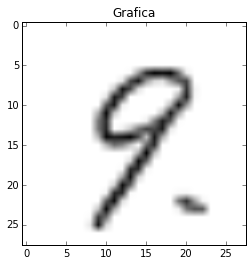

Prediccion 7


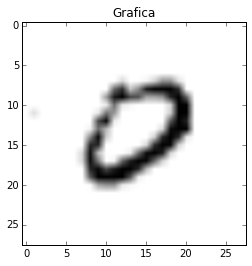

Prediccion 2


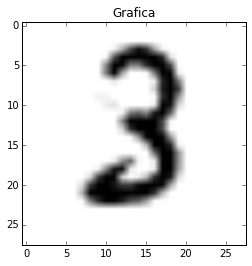

Prediccion 7


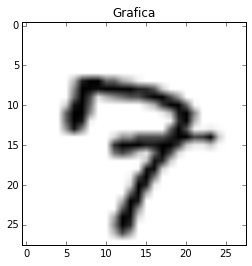

Prediccion 0


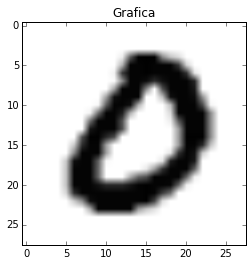

Prediccion 3


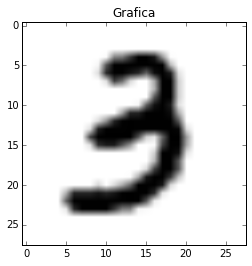

Prediccion 0


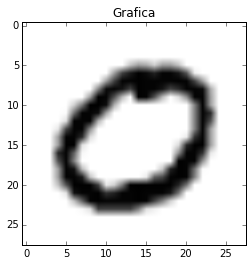

Prediccion 3


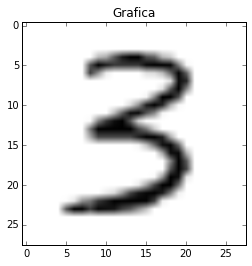

In [53]:
for idx in xrange( 10 ):
    print "Prediccion", sol[idx]
    printImage( testData[idx] , label=0)

In [54]:
#salida = [[index + 1, x] for index, x in enumerate(sol)]
salida = zip( range(1, len(sol)+1 ) , sol )

In [56]:
np.savetxt('Data/submission.csv', salida, delimiter=',', fmt='%d,%d', header='ImageId,Label')

In [57]:
%%cmd
type Data\submission.csv

Microsoft Windows [Versi�n 6.1.7601]
Copyright (c) 2009 Microsoft Corporation. Reservados todos los derechos.

C:\Users\Lin\Documents\GitHub\MachineLearning\Taller 3>type Data\submission.csv
# ImageId,Label
1,2
2,0
3,9
4,7
5,2
6,7
7,0
8,3
9,0
10,3
11,5
12,7
13,4
14,0
15,4
16,0
17,3
18,1
19,9
20,0
21,9
22,1
23,1
24,5
25,7
26,4
27,2
28,7
29,7
30,7
31,7
32,5
33,4
34,2
35,6
36,2
37,9
38,5
39,1
40,6
41,7
42,7
43,4
44,9
45,8
46,7
47,8
48,8
49,6
50,1
51,6
52,8
53,8
54,3
55,8
56,2
57,1
58,2
59,1
60,0
61,4
62,1
63,7
64,0
65,0
66,0
67,1
68,9
69,0
70,1
71,6
72,5
73,8
74,8
75,2
76,8
77,2
78,9
79,2
80,2
81,5
82,9
83,1
84,0
85,9
86,2
87,4
88,3
89,6
90,7
91,2
92,0
93,6
94,6
95,8
96,4
97,3
98,9
99,7
100,7
101,0
102,8
103,2
104,0
105,7
106,3
107,0
108,5
109,0
110,3
111,0
112,0
113,4
114,7
115,1
116,7
117,1
118,1
119,5
120,2
121,3
122,7
123,2
124,8
125,6
126,3
127,8
128,7
129,8
130,4
131,3
132,5
133,6
134,0
135,0
136,0
137,3
138,1
139,5
140,0
141,4
142,3
143,4
144,5
145,5
146,8
147,7
148,7
149,2
150,8
1

Los resultados pueden verificarse <a href="https://www.kaggle.com/jfcowboy/results">Aca</a>


<img src="Data/Resultado1Kaggle.PNG">

Ahora probando el envio con otra version del SVM:

In [ ]:
labelP3, dataP3 = separarDatos( totalTrain )
clf = svm.SVC( C=100 )
clf.fit(dataP3, labelP3)
sol = clf.predict( testData )
#salida = [[index + 1, x] for index, x in enumerate(sol)]
salida = zip( range(1, len(sol)+1 ) , sol )

In [ ]:
np.savetxt('Data/submission2.csv', salida, delimiter=',', fmt='%d,%d', header='ImageId,Label')

In [ ]:
%%cmd
type Data\submission2.csv

##Punto 4

####A  - Build training and test data sets

In [2]:
def buildDictionary( fromFile, toFile ):
    data = open( fromFile )
    lines = data.read().splitlines()
    arch = []
    for line in lines:
        words = line.split()
        for word in words:
            if len(word)<=4 or (word[0]>='0' and word[0]<='9'):
                continue
            arch.append(word)
    np.savetxt(toFile, arch, fmt='%s')

In [3]:
buildDictionary("Data/prevDataEs.txt", "Data/dataEs.txt")
buildDictionary("Data/prevDataEn.txt", "Data/dataEn.txt")

In [203]:
%%cmd
type Data\dataEn.txt
type Data\dataEs.txt

Microsoft Windows [Versi�n 6.3.9600]
(c) 2013 Microsoft Corporation. Todos los derechos reservados.

C:\Users\JuanFelipe\Documents\GitHub\MachineLearning\Taller 3>type Data\dataEn.txt
which
their
would
there
could
other
about
little
should
great
before
these
after
first
never
shall
where
those
himself
without
through
being
might
again
think
every
people
thought
under
found
still
place
while
young
though
against
things
years
nothing
right
another
house
world
three
always
night
between
heart
because
thing
seemed
looked
called
whole
heard
country
asked
going
better
having
something
moment
father
among
course
hands
woman
enough
words
mother
almost
small
cannot
water
however
light
quite
brought
whose
given
turned
taken
morning
myself
Gutenberg
until
since
power
themselves
rather
began
present
voice
others
white
works
money
death
stood
within
together
large
matter
often
certain
herself
friend
order
round
anything
means
believe
passed
public
state
hundred
children
alone
above
person
already
r

Se extraen los datos y se crea un nuevo Dataset el cual contiene 8800 palabras para español y 8430 palabras para inglés.

In [4]:
accents = {'á' : 'a', 'Á' : 'a',
         'é' : 'e', 'É' : 'e',
         'í' : 'i', 'Í' : 'i',
         'ó' : 'o', 'Ó' : 'o',
         'ú' : 'u', 'Ú' : 'u',
         'ñ' : 'n', 'Ñ' : 'n',
         'ü' : 'u', 'Ü' : 'u',
         "'" : ''}
dataEs = open("Data/dataEs.txt")
lines = dataEs.read().splitlines()

palabrasEs = []
for line in lines:
    for a in accents:
        line = line.replace(a,accents[a])  
    line = line.lower()
    palabrasEs.append([1,line])

print palabrasEs

[[1, 'esta'], [1, 'aqui'], [1, 'vamos'], [1, 'ahora'], [1, 'estoy'], [1, 'tengo'], [1, 'cuando'], [1, 'estas'], [1, 'puedo'], [1, 'como'], [1, 'quiero'], [1, 'solo'], [1, 'tiene'], [1, 'gracias'], [1, 'bueno'], [1, 'hacer'], [1, 'todos'], [1, 'tienes'], [1, 'puede'], [1, 'sabes'], [1, 'porque'], [1, 'quien'], [1, 'nunca'], [1, 'donde'], [1, 'quieres'], [1, 'favor'], [1, 'senor'], [1, 'tiempo'], [1, 'verdad'], [1, 'estaba'], [1, 'mejor'], [1, 'estan'], [1, 'hombre'], [1, 'usted'], [1, 'mucho'], [1, 'entonces'], [1, 'siento'], [1, 'tenemos'], [1, 'puedes'], [1, 'alguien'], [1, 'hasta'], [1, 'anos'], [1, 'sobre'], [1, 'decir'], [1, 'siempre'], [1, 'cosas'], [1, 'tambien'], [1, 'antes'], [1, 'estar'], [1, 'estamos'], [1, 'noche'], [1, 'nadie'], [1, 'quiere'], [1, 'parece'], [1, 'nosotros'], [1, 'padre'], [1, 'trabajo'], [1, 'gente'], [1, 'donde'], [1, 'mismo'], [1, 'hecho'], [1, 'ellos'], [1, 'dinero'], [1, 'hablar'], [1, 'seguro'], [1, 'claro'], [1, 'estas'], [1, 'lugar'], [1, 'mundo'], [

In [5]:
dataEn = open("Data/dataEn.txt")
lines = dataEn.read().splitlines()

palabrasEn = []
for line in lines:
    line = line.replace("-","")
    palabrasEn.append([0,line.lower()])

print palabrasEn
    

[[0, 'which'], [0, 'their'], [0, 'would'], [0, 'there'], [0, 'could'], [0, 'other'], [0, 'about'], [0, 'little'], [0, 'should'], [0, 'great'], [0, 'before'], [0, 'these'], [0, 'after'], [0, 'first'], [0, 'never'], [0, 'shall'], [0, 'where'], [0, 'those'], [0, 'himself'], [0, 'without'], [0, 'through'], [0, 'being'], [0, 'might'], [0, 'again'], [0, 'think'], [0, 'every'], [0, 'people'], [0, 'thought'], [0, 'under'], [0, 'found'], [0, 'still'], [0, 'place'], [0, 'while'], [0, 'young'], [0, 'though'], [0, 'against'], [0, 'things'], [0, 'years'], [0, 'nothing'], [0, 'right'], [0, 'another'], [0, 'house'], [0, 'world'], [0, 'three'], [0, 'always'], [0, 'night'], [0, 'between'], [0, 'heart'], [0, 'because'], [0, 'thing'], [0, 'seemed'], [0, 'looked'], [0, 'called'], [0, 'whole'], [0, 'heard'], [0, 'country'], [0, 'asked'], [0, 'going'], [0, 'better'], [0, 'having'], [0, 'something'], [0, 'moment'], [0, 'father'], [0, 'among'], [0, 'course'], [0, 'hands'], [0, 'woman'], [0, 'enough'], [0, 'wo

In [6]:
palabras = palabrasEn + palabrasEs
trainWords, testWords = skl.cross_validation.train_test_split(palabras, test_size=0.40)
trainWords = np.array( trainWords )
testWords = np.array( testWords )
print "Tamano Train {0}, Tamano Test {1}".format( len(trainWords), len(testWords) )


Tamano Train 10372, Tamano Test 6915


####B - Program a string kernel

In [7]:
#Funcion de kernel que cuenta conincidencias de letras por posicion

def kernelWords1(word1, word2):
    cnt = 0
    minTam = min(len(word1),len(word2))
    for k in xrange(minTam):
        if(word1[k] == word2[k]):
            cnt = cnt + 1
    return cnt

####C - Train a SVM using precomputed kernel

In [8]:
KK = []
def getKernel( X , kernel):
    global KK
#     print self, X, self.kernel
    KK = []
    for x in X:
        row = []
        for y in X:
            res = kernel(x, y)
            row.append( res )
        KK.append(row)
        
    return np.array(KK)

In [19]:
print KK[99][:100]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]


In [10]:
precompKernel = getKernel(palabras,kernelWords1)
print precompKernel

MemoryError: 

In [20]:
palabras = None

In [21]:
clf = svm.SVC( kernel='precomputed' )
clf.fit( KK, map(int, trainWords.T[0]) )

MemoryError: 